## Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms.  

### Part 0: Explore BlackjackEnv

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [1]:
from collections import defaultdict
import numpy as np
import sys

In [2]:
from plot_utils import plot_blackjack_values
from plot_utils import plot_policy
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import gymnasium as gym
env = gym.make('Blackjack-v1', sab=True)

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [4]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [5]:
for i_episode in range(3):
    observation = env.reset()
    print(observation)
    while True:
        # action = 1 
        action = env.action_space.sample()
        observation, reward, done, truncated, info = env.step(action)
        print(action, observation, reward)
        if done:
            print('End game!')
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

((21, 10, 1), {})
0 (21, 10, 1) 1.0
End game!
You won :)

((12, 10, 0), {})
1 (20, 10, 0) 0.0
1 (30, 10, 0) -1.0
End game!
You lost :(

((9, 5, 0), {})
0 (9, 5, 0) 1.0
End game!
You won :)



### Part 1: MC Prediction: State Values

In this section, you will write your own implementation of MC prediction (for estimating the state-value function).

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [6]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()[0]
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, truncated, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit` function.*)

In [7]:
for i in range(3):
    print(generate_episode_from_limit(env))

[((18, 4, 0), 1, 0.0), ((20, 4, 0), 0, 1.0)]
[((12, 10, 0), 1, -1.0)]
[((11, 4, 0), 1, 0.0), ((21, 4, 0), 0, 1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.  For example, if your code returns the following output:
```
{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...
```
then the value of state `(4, 7, False)` was estimated to be `-0.38775510204081631`.

If you are unfamiliar with how to use `defaultdict` in Python, you are encouraged to check out [this source](https://www.accelebrate.com/blog/using-defaultdict-python/).

In [8]:
def create_policy(env):
    # create policy object 
    policy = defaultdict(int)

    for i in range(env.observation_space[0].n):
        for j in range(env.observation_space[1].n):
            for k in range(env.observation_space[2].n):
                if i >= 20: # sutton and barto policy for Example 5.1 Blackjack 
                    policy[(i, j, k)] = 0 # stick
                else:
                    policy[(i, j, k)] = 1 # hit

    return policy


def plot_policy(policy, usable_ace=0):

    player_count, dealer_count = np.meshgrid(
            # players count, dealers face-up card
            np.arange(12, 22),
            np.arange(1, 11),
        )

    policy_grid = np.apply_along_axis(
            lambda obs: policy[(obs[0], obs[1], usable_ace)],
            axis=2,
            arr=np.dstack([player_count, dealer_count]),
        )
    sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False);
    plt.gca().set_title(f"Policy: usable_ace = {usable_ace}")
    plt.gca().set_xlabel("Player sum")
    plt.gca().set_ylabel("Dealer showing")
    plt.gca().set_xticklabels(range(12, 22));
    plt.gca().set_yticklabels(["A"] + list(range(2, 11)), fontsize=12);

policy = create_policy(env)


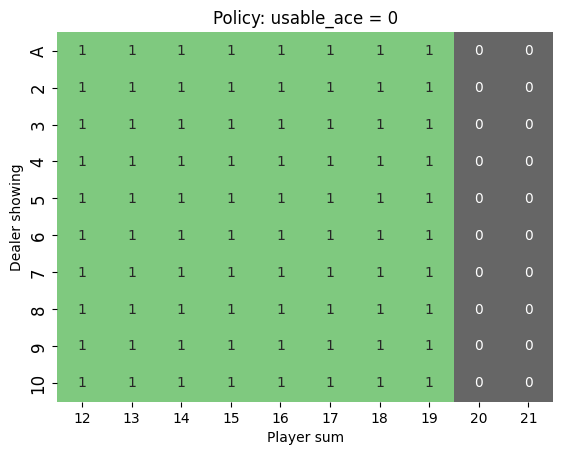

In [9]:
plot_policy(policy, usable_ace=0)


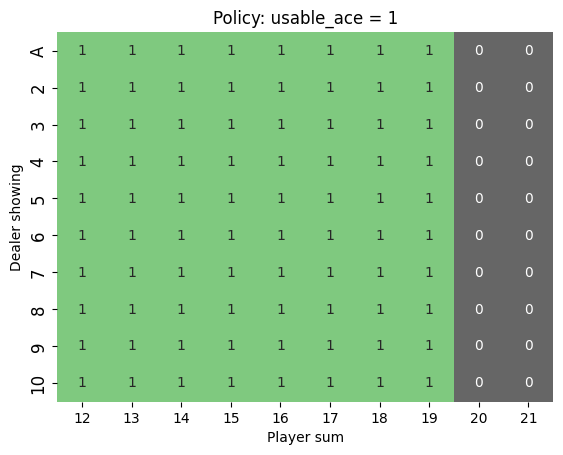

In [10]:

plot_policy(policy, usable_ace=1)

In [11]:
def generate_episode(env, policy):
    '''
    Args:
    - env: blackjack gym environment
    - policy: 
    Returns:
    - list: a list of tuples (state, action, reward) for each state in the episode until termination
    '''

    # initialize list 
    episode = []

    # reset environment 
    terminated = False
    state, _ = env.reset()

    # while not done, i.e. until terminated = True 
    while not terminated:
        # get an action according to policy 
        action = policy[state]

        # execute the action in our environment and receive infos from the environment
        next_state, reward, terminated, truncated, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state 

        # check for termination
        if terminated:
            break 
    
    return episode


In [48]:
def mc_prediction_nz(env, policy, num_episodes, gamma=1.0):
    
    # initialize empty dictionary of lists
    # returns = defaultdict(np.float64)
    returns_sum = defaultdict(np.float64)
    returns_counts = defaultdict(np.float64)
    V = defaultdict(np.float64)

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # generate an episode of data using the policy 
        episode = generate_episode(env, policy)
        
        # initialize returns for this episode 
        G = 0
    
        # loop over each step of episode backwards
        for t, (state, action, reward) in enumerate(reversed(episode)):
            t = len(episode) - t
            G = G*gamma + reward 
            
            # For first-visit MC
            # check if this state has never been seen before in the episode (and therefore is the first visit to the state)
            if state not in [tup[0] for tup in episode[:t-1]]: 
                # if we've never seen the state in any episode, then initialize counts and sum
                if state not in returns_sum:
                    # initialize sum and count
                    returns_sum[state] = 0
                    returns_counts[state] = 0
                # add the return and increment the count (for the purposes of taking the mean later)
                returns_sum[state] += G
                returns_counts[state] += 1
        
    #  take the average of the returns for each state and assign to value function object
    for state in returns_sum:
        V[state] = returns_sum[state] / returns_counts[state]

    return V


Episode 10000/10000.

Use the cell below to calculate and plot the state-value function estimate.  (_The code for plotting the value function has been borrowed from [this source](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py) and slightly adapted._)

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 10000/10000.

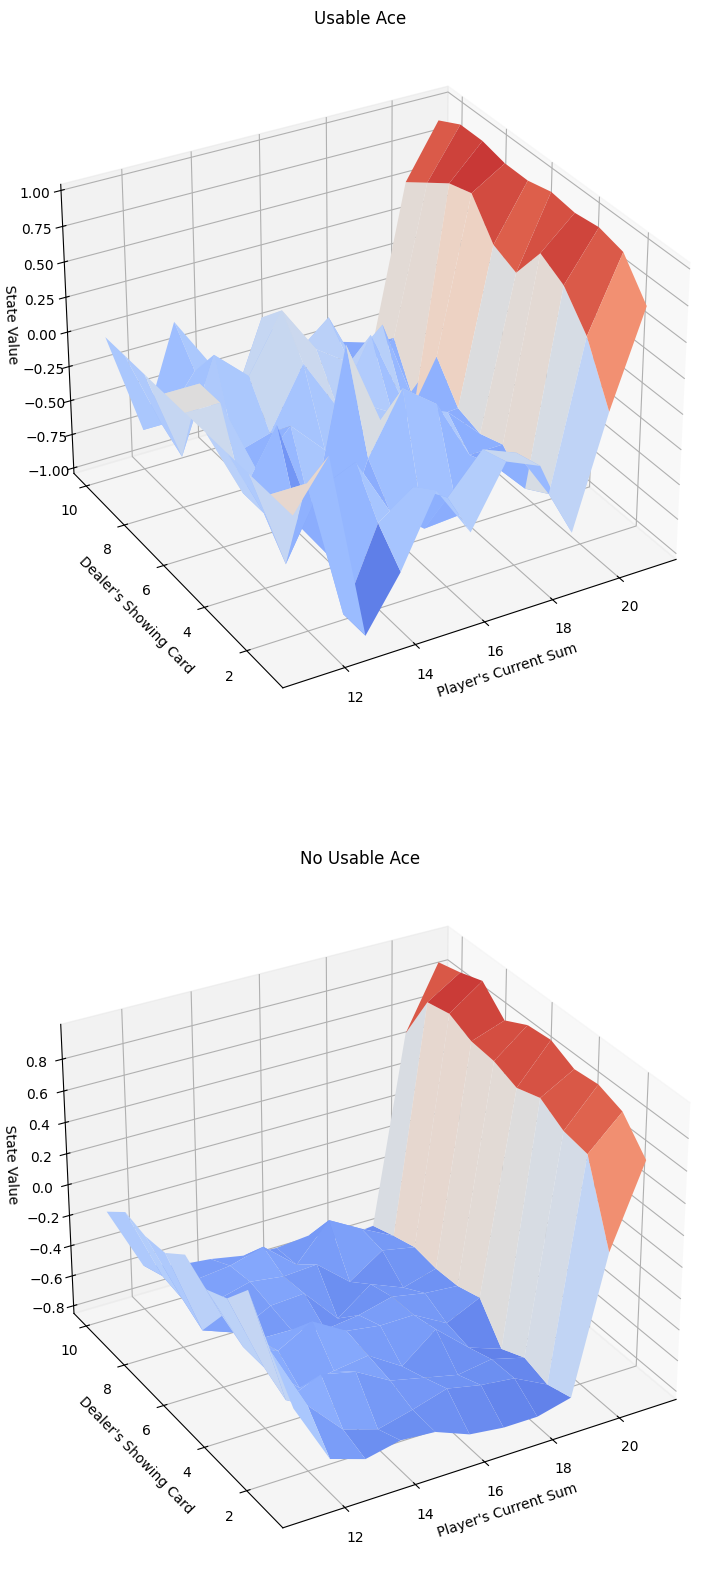

In [49]:
# obtain the value function
# create policy 
policy = create_policy(env)
V = mc_prediction_nz(env, policy, num_episodes=10000, gamma=1.0)

# plot the value function
plot_blackjack_values(V)
plt.show()


In [43]:
def generate_episode_exploring_starts(env, q_values):
    state = env.reset()
    action = np.random.choice(env.action_space.n)  # Initial random action for exploring starts
    episode = []

    # Generate an episode with exploring starts
    while True:
        next_state, reward, done, truncated, info = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state
        # action = np.random.choice(env.action_space.n)
        action = np.argmax(q_values[state])
    
    return episode

In [44]:
q_values = defaultdict(lambda: np.zeros(env.action_space.n))
generate_episode_exploring_starts(env, q_values)

[(((14, 7, 0), {}), 1, -1.0)]

### 5.3 Monte Carlo Policy Iteration with Exploring Starts

In [51]:
# def monte_carlo_es(env):
num_episodes = 1000
gamma = 1.0

# initialize policy, state-action value dictionary, and returns dictionary 
policy = create_policy(env) # initialize policy 
Q = defaultdict()
returns = defaultdict()

# loop over episodes
for i_episode in range(1, num_episodes+1):
    # monitor progress
    if i_episode % 1000 == 0:
        print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
        sys.stdout.flush()
    
    # generate an episode of data using the policy 
    episode = generate_episode_exploring_starts(env, policy)
    
    # initialize returns for this episode 
    G = 0

    # loop over each step of episode backwards
    for t, (state, action, reward) in enumerate(reversed(episode)):
        t = len(episode) - t
        G = G*gamma + reward 
        # Check if the state is visited for the first time in the episode
        if (state, action) not in episode[:t]:
            # if this is the first time we've seen this state, initialize sum and count
            if state not in returns_sum:
                returns_sum[state] = 0
                returns_counts[state] = 0
            # add the return and increment the count (for the purposes of taking the mean later)
            returns_sum[state] += G
            returns_counts[state] += 1
    
#  take the average of the returns for each state and assign to value function object
for state in returns_sum:
    V[state] = returns_sum[state] / returns_counts[state]


return V





### Part 2: MC Prediction: Action Values

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [10]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [11]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((11, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[((15, 5, False), 1, 0), ((16, 5, False), 0, -1.0)]
[((12, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [12]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        episode = generate_episode_from_limit_stochastic(env)
        seen = []
        for t, (state, action, reward) in enumerate(episode):
            if (state, action) not in seen:
                seen.append((state, action))
                N[state][action] += 1
                G = 0
                for fi, (fstate, faction, freward) in enumerate(episode[t:]):
                    G += (gamma**fi)*freward
                returns_sum[state][action] += G        
    #V = defaultdict(np.float64)
    for k in N.keys():
        for a in range(env.action_space.n):
            Q[k][a] = returns_sum[k][a] / N[k][a]
            
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

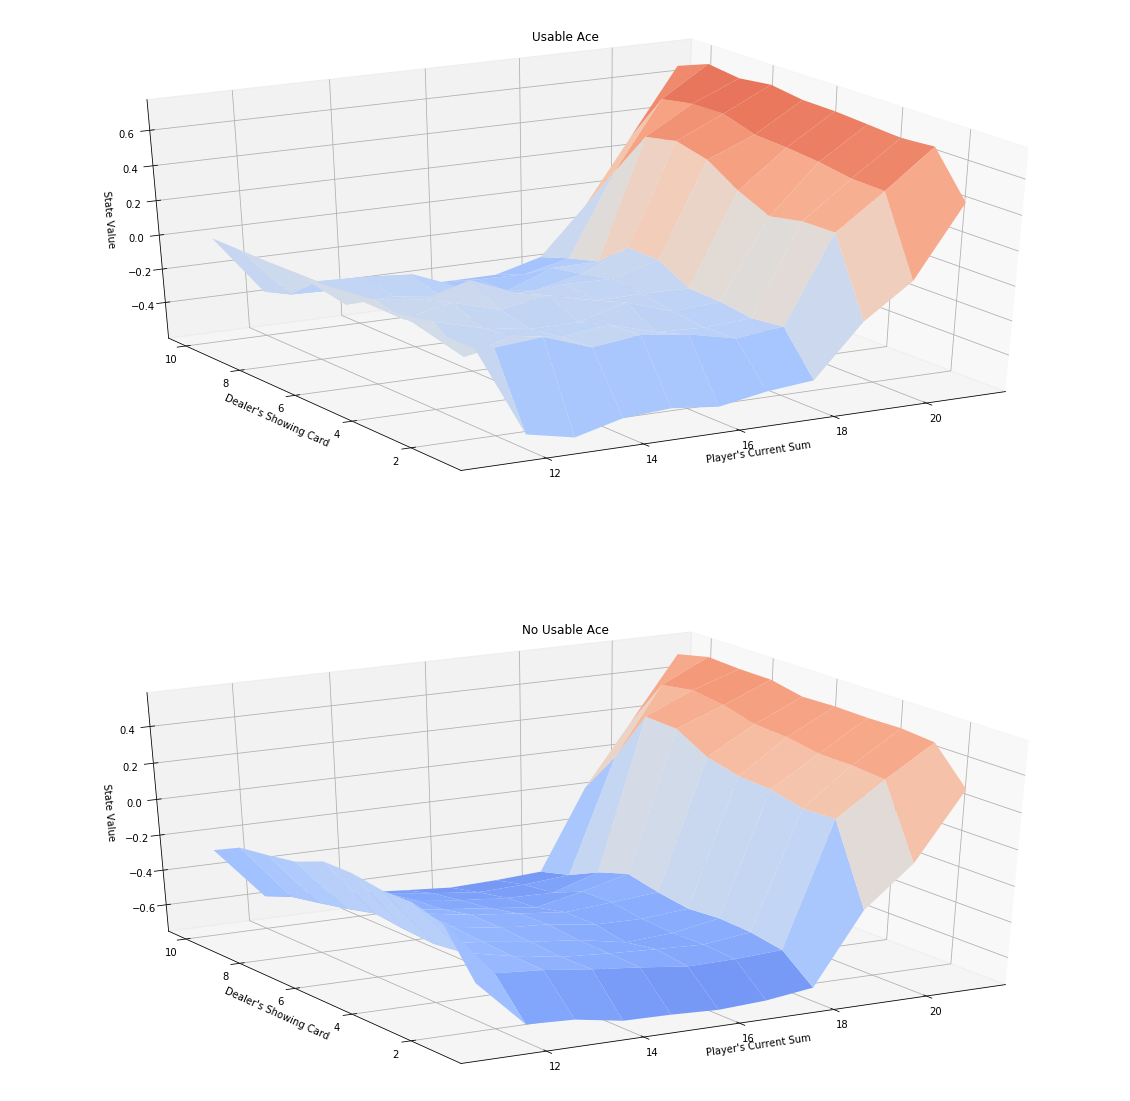

In [13]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 3: MC Control: GLIE

Greedy in the Limit with Infinite Exploration

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [5]:
def e_greedy_policy_creation(Q, epsilon, nA):
    policy = np.ones(nA) * (epsilon / nA)
    bestAction = np.argmax(Q)
    policy[bestAction] = 1 - epsilon + (epsilon/nA)
    return policy

def generate_episode_from_policy(env, policy):
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(2), p=policy)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [51]:
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    policy = defaultdict(lambda: np.zeros(nA))
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
#        epsilon = max(1/i_episode, 0.1)
        epsilon = 1.0/((i_episode/10000)+1)


        policy = e_greedy_policy_creation(Q, epsilon, nA)
        
        episode = generate_episode_from_policy(env, policy)
        
        seen = []

        for t, (state, action, reward) in enumerate(episode):
            if state not in seen:
                seen.append(state)
                N[state][action] += 1
                G = 0
                                
                for fi, (fstate, faction, freward) in enumerate(episode[t:]):
                    G += (gamma**fi)*freward
                
                Q[state][action] += (G - Q[state][action])/N[state][action]
                
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
            
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [59]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

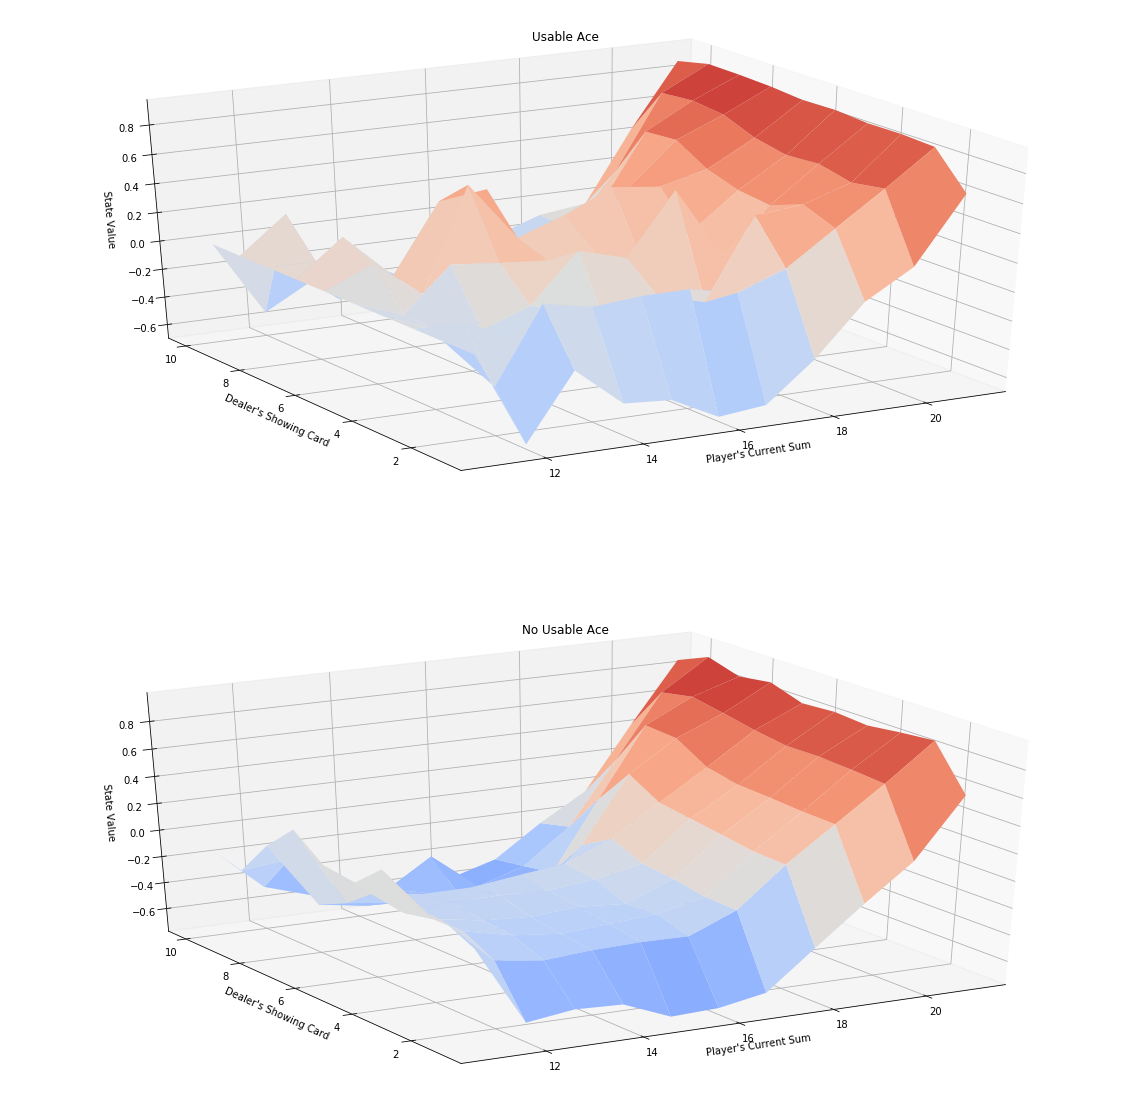

In [60]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

Finally, we visualize the policy that is estimated to be optimal.

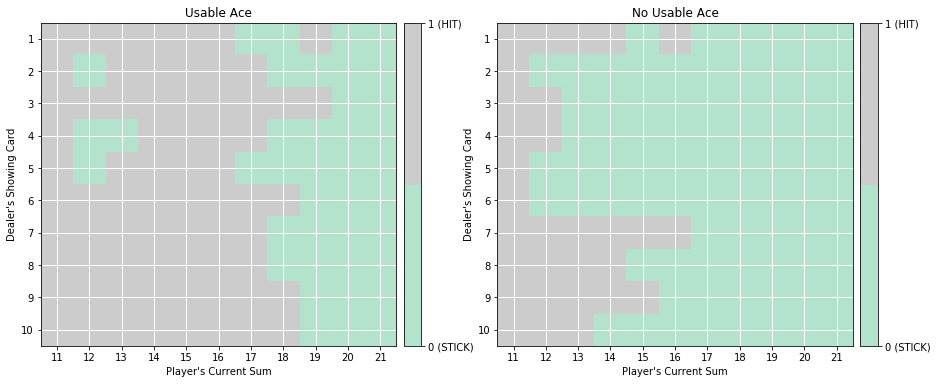

In [61]:
# plot the policy
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$ and/or run the algorithm for more episodes to attain better results.

### Part 4: MC Control: Constant-$\alpha$

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [6]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    policy = defaultdict(lambda: np.zeros(nA))
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
#        epsilon = max(1/i_episode, 0.1)
        epsilon = 1.0/((i_episode/10000)+1)


        policy = e_greedy_policy_creation(Q, epsilon, nA)
        
        episode = generate_episode_from_policy(env, policy)
        
        seen = []

        for t, (state, action, reward) in enumerate(episode):
            if state not in seen:
                seen.append(state)
                G = 0
                                
                for fi, (fstate, faction, freward) in enumerate(episode[t:]):
                    G += (gamma**fi)*freward
                
                Q[state][action] += alpha*(G - Q[state][action])
                
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
            
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [14]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 750000, 0.008)

Episode 750000/750000.

Next, we plot the corresponding state-value function.

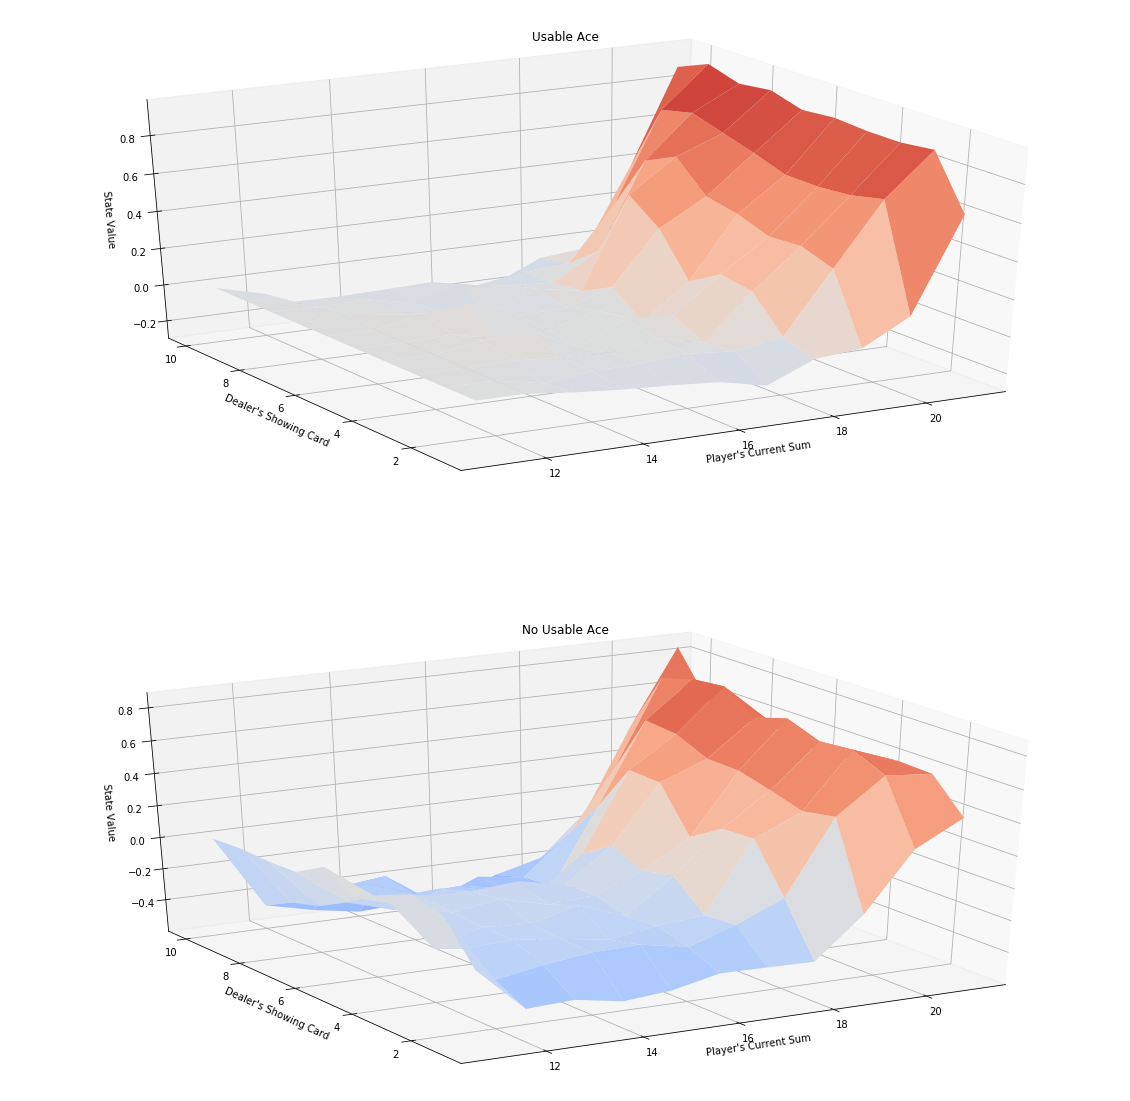

In [15]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

Finally, we visualize the policy that is estimated to be optimal.

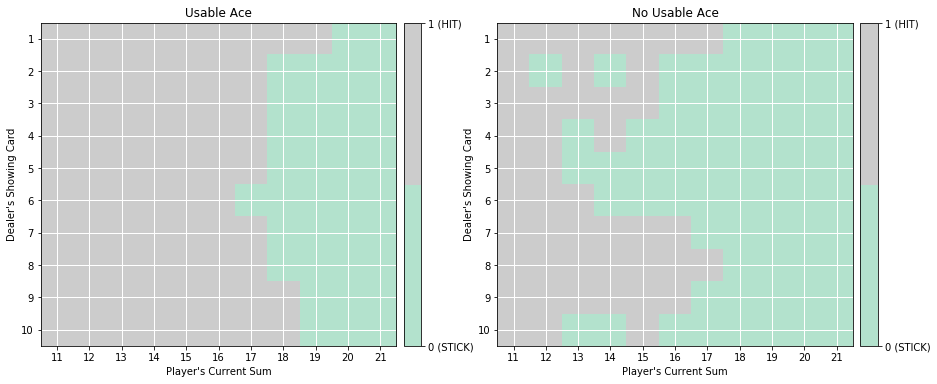

In [16]:
# plot the policy
plot_policy(policy_alpha)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.